In [1]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
from concurrent.futures import ProcessPoolExecutor, Future
from itertools import product

from utils import *

mpl.rcParams.update(rcParams)

In [2]:
%%bash
cd .. && make clean && make

src/Ex3_2024.cpp:54:74: warning: unused parameter 't' [-Wunused-parameter]
        valarray<long double> get_f(const valarray<long double>& x, long double t) {
                                                                                ^
1 warning generated.


In [3]:
config_name = 'transfert'
conf = load_conf(config_name)

In [4]:
# G = 6.674e-11
# a = (conf['r0'] + conf['r1']) / 2

# tFin = 2 * np.pi * np.sqrt(conf['a']**3 / (8 * (G * conf['m2'])))
# tFin = 2 * np.pi * np.sqrt(a**3 / (G * conf['m2']) ) 
# print(tFin)

In [5]:
params_variations = {
    # 'nsteps': [200000],
    # 'tol': [1e-5],
    'nsteps': [5000],
    'adapt': ['true', 'false'],
    'tol': [100],
}
all_params = tuple(
    {a: b for a, b in zip(params_variations.keys(), c)} for c in product(*params_variations.values())
)

In [6]:
count = 0
def done(fut: Future) -> None:
    global count
    count += 1
    print(f'\rRunning simulations... Done {count}/{len(all_params)}', end='')

# Run simulations *IN PARALLEL*
outputs = []
with ProcessPoolExecutor(max_workers=8) as p:
    for params in all_params:
        options = stringify_dict(params)
        output_file = f"{data_path}{config_name},{options}.out"
        outputs.append(output_file)
        future = p.submit(run, f'{config_path}{config_name}{config_ext}', output_file, params)
        future.add_done_callback(done)

Running simulations... Done 2/2

In [7]:
# Load stuff in memory
all_data = {}

for file, params in zip(outputs, all_params):
    data = np.loadtxt(path + file)
    all_data[file] = (params, np.copy(data))

# Plots!

nsteps adaptatif: 67.0


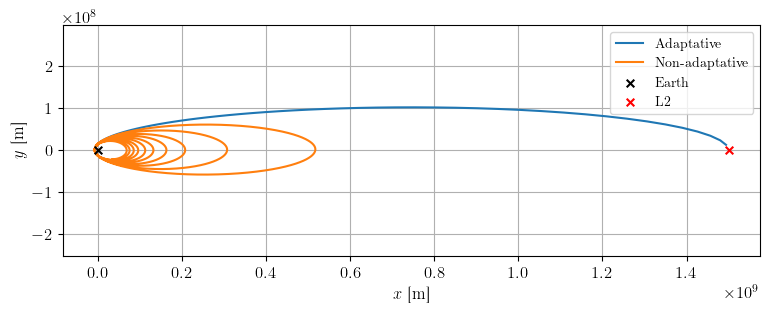

In [8]:
plt.figure(figsize=(9, 3))

for (params, data) in all_data.values():
    t, x, y = data[:,0], data[:,1], data[:,2]
    label = ''
    if params['adapt']=='true':
        label = 'Adaptative'
        print(f'nsteps adaptatif: {data[-1,-1]}')

    else:
        label='Non-adaptative'
    plt.plot(x, y, label=label)
    
plt.scatter(0, 0, color='black', marker='x', label='Earth', s=30, zorder=2)
plt.scatter(1.5e9, 0, color='red', marker='x', label='L2', s=30, zorder=3)


plt.axis('equal')
plt.grid()
plt.legend()

plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')

plt.savefig(export_path + 'transfert_comparaison.pdf')

nsteps adaptatif: 67.0


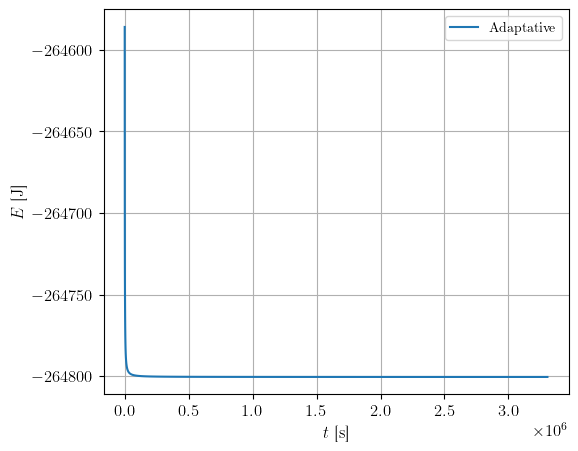

Text(0, 0.5, '$E$ [J]')

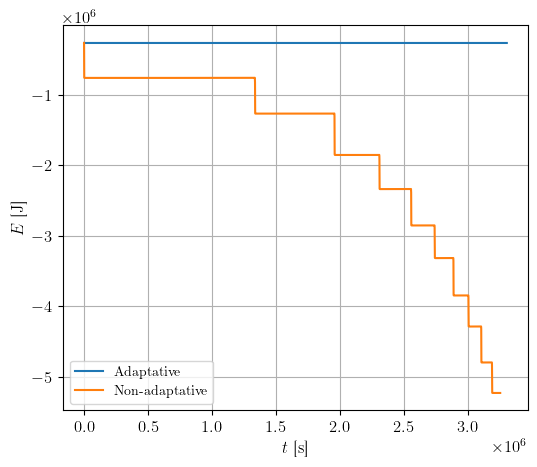

In [9]:
for (params, data) in all_data.values():
    t, energy = data[:,0], data[:,5]
    label = ''
    nsteps = 0
    if params['adapt']=='true':
        label = 'Adaptative'
        print(f'nsteps adaptatif: {data[-1,-1]}')
        plt.plot(t, energy, label=label)
        plt.grid()
        plt.legend()

        plt.xlabel(r'$t$ [s]')
        plt.ylabel(r'$E$ [J]')
        plt.show()
    else:
        label='Non-adaptative'
    plt.plot(t, energy, label=label)
    # plt.show()


plt.grid()
plt.legend()

plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$E$ [J]')
